### Data
[ocn.calcs.004 Coral Reef Projected Acidification Areas by MEOW per Decade](https://resourcewatch.carto.com/u/wri-rw/dataset/ocn_calcs_004_reef_projected_acidification_areas_by_meow_per_de)  
from [GEE asset](https://code.earthengine.google.com/?asset=projects/resource-watch-gee/ocean-watch/calcs_reef-acidification_areas-100m)  

Calculations based on:  
- [bio.004.rw2 Coral Reef Locations](https://resourcewatch.carto.com/u/wri-rw/tables/bio_004a_coral_reef_locations_edit/)  
- [ocn.006a.rw0 Projected Ocean Acidification](https://code.earthengine.google.com/?asset=projects/resource-watch-gee/ocn_006_projected_ocean_acidification)

[Google Earth Engine calculation script](https://code.earthengine.google.com/e4b67038983d7eec477578a91d764b16?noload=true)

----
_Author: Peter Kerins_  
_Created: 28 January 2021_  

In [7]:
import numpy as np
import vega
import json
from vega import Vega

### Standalone specification  
(eg for use with https://vega.github.io/editor/#/)  

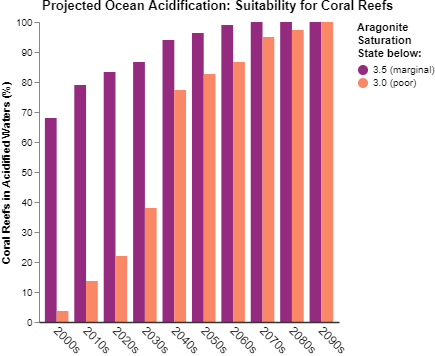

In [2]:
spec=json.loads("""
{
  "width": 300,
  "height": 300,
  "autosize": {"type": "pad", "resize": true, "contains": "padding"},
  "signals": [
    {
      "name": "hover",
      "value": null,
      "on": [
        {"events": "@cell:mouseover", "update": "datum"},
        {"events": "@cell:mouseout", "update": "null"}
      ]
    }
  ],
  "data": [
    {
      "name": "table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT decade_start, ass_threshold, SUM(acid_area) AS acid_area, SUM(total_area) AS total_area, SUM(acid_area)/SUM(total_area) AS acid_fraction, SUM(SUM(acid_area)/SUM(total_area)) OVER (ORDER BY decade_start) AS acid_fraction_running FROM (SELECT cartodb_id, '3.5 (marginal)' AS ass_threshold, unnest(array[2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090]) AS decade_start, unnest(array[_2000s_35, _2010s_35, _2020s_35, _2030s_35, _2040s_35, _2050s_35, _2060s_35, _2070s_35, _2080s_35, _2090s_35]) AS acid_area, reefarea AS total_area FROM ocn_calcs_004_reef_projected_acidification_areas_by_meow_per_decade) AS decadal_data GROUP BY decade_start, ass_threshold UNION ALL SELECT decade_start, ass_threshold, SUM(acid_area) AS acid_area, SUM(total_area) AS total_area, SUM(acid_area)/SUM(total_area) AS acid_fraction, SUM(SUM(acid_area)/SUM(total_area)) OVER (ORDER BY decade_start) AS acid_fraction_running FROM (SELECT cartodb_id, '3.0 (poor)' AS ass_threshold, unnest(array[2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090]) AS decade_start, unnest(array[_2000s_30, _2010s_30, _2020s_30, _2030s_30, _2040s_30, _2050s_30, _2060s_30, _2070s_30, _2080s_30, _2090s_30]) AS acid_area, reefarea AS total_area FROM ocn_calcs_004_reef_projected_acidification_areas_by_meow_per_decade) AS decadal_data GROUP BY decade_start, ass_threshold ORDER BY decade_start ASC, ass_threshold DESC",
      "format": {"type": "json", "property": "rows"},
      "transform": [
        {
          "type": "formula",
          "as": "acid_percentage",
          "expr": "datum.acid_fraction * 100.0"
        },
        {
          "type": "formula",
          "as": "acid_percentage_running",
          "expr": "datum.acid_fraction_running * 100.0"
        },
        {"type": "filter", "expr": "datum.decade_start < 2100"}
      ]
    }
  ],
  "title": "Projected Ocean Acidification: Suitability for Coral Reefs",
  "scales": [
    {
      "name": "xscale",
      "type": "band",
      "domain": {"data": "table", "field": "decade_start"},
      "range": "width",
      "padding": 0.2
    },
    {
      "name": "yscale",
      "type": "linear",
      "domain": {"data": "table", "field": "acid_percentage_running"},
      "range": "height",
      "round": true,
      "zero": true,
      "nice": true
    },
    {
      "name": "color",
      "type": "ordinal",
      "domain": {"data": "table", "field": "ass_threshold"},
      "range": [
        "#942B7F",
        "#FA8866"
      ]
    }
  ],
  "axes": [
    {
      "orient": "left",
      "scale": "yscale",
      "title": "Coral Reefs in Acidified Waters (%)"
    },
    {
      "orient": "bottom",
      "scale": "xscale",
      "tickSize": 0,
      "labelPadding": 4,
      "zindex": 1,
      "encode": {
        "labels": {
          "interactive": true,
          "update": {
            "text": {"signal": "datum.value + 's'"},
            "fill": {"value": "black"},
            "angle": {"value": 45},
            "fontSize": {"value": 12},
            "align": {"value": "left"},
            "baseline": {"value": "middle"},
            "dy": {"value": 2},
            "dx": {"value": 1}
          },
          "hover": {"fill": {"value": "firebrick"}}
        },
        "domain": {
          "update": {"stroke": {"value": "#333"}, "strokeWidth": {"value": 1.5}}
        }
      }
    }
  ],
  "marks": [
    {
      "type": "group",
      "from": {
        "facet": {"data": "table", "name": "facet", "groupby": "decade_start"}
      },
      "encode": {"enter": {"x": {"scale": "xscale", "field": "decade_start"}}},
      "signals": [{"name": "width", "update": "bandwidth('xscale')"}],
      "scales": [
        {
          "name": "pos",
          "type": "band",
          "range": "width",
          "domain": {"data": "facet", "field": "ass_threshold"}
        }
      ],
      "marks": [
        {
          "name": "bars",
          "from": {"data": "facet"},
          "type": "rect",
          "encode": {
            "enter": {
              "x": {"scale": "pos", "field": "ass_threshold"},
              "width": {"scale": "pos", "band": 1},
              "y": {"scale": "yscale", "field": "acid_percentage_running"},
              "y2": {"scale": "yscale", "value": 0},
              "fill": {"scale": "color", "field": "ass_threshold"},
              "tooltip": {
                "signal": "{title:'Coral in waters with aragonite saturation state below ' + datum.ass_threshold + ' in ' + datum.decade_start + 's', 'Fraction of global reef area':format(datum.acid_fraction_running,'.1%')}"
              }
            },
            "hover": {"fillOpacity": {"value": 0.5}},
            "update": {"fillOpacity": {"value": 1}}
          }
        }
      ]
    }
  ],
  "legends": [
    {
      "title": ["Aragonite", "Saturation", "State below:"],
      "fill": "color",
      "orient": "right"
    }
  ]
}
""")
vegaview=dict(spec)
Vega(vegaview)

### Resource Watch specification
API ID: 8669c45d-0950-4d53-96b2-ebdaf128c520  
https://resourcewatch.org/embed/widget/8669c45d-0950-4d53-96b2-ebdaf128c520

In [ ]:
spec=json.loads("""

""")
vegaview=dict(spec)
Vega(vegaview)

### Script to pass modified specification to RW via API
Based on [template in data-team-tool](https://github.com/resource-watch/data-team-tools/blob/6bf21e42d724b5f72060dd2f833864df8acad09e/map_embed_widget/embed_widget.py)

In [3]:
# import LMIPy as lmi
import os
import json
import requests
import dotenv
dotenv.load_dotenv(os.path.abspath(os.getenv('RW_ENV')))

True

In [8]:
# input widget API ID for the empty advanced widget you have created and want to overwrite
dataset_id = 'cb4db45c-e1e8-44a4-837a-e513d3c9d9fe'
widget_to_overwrite = '8669c45d-0950-4d53-96b2-ebdaf128c520'

# replace the empty dictionary with the code from the vega editor
# replace true with True and null with None
vega = {
  "width": 300,
  "height": 300,
  "autosize": {"type": "pad", "resize": True, "contains": "padding"},
  "signals": [
    {
      "name": "hover",
      "value": None,
      "on": [
        {"events": "@cell:mouseover", "update": "datum"},
        {"events": "@cell:mouseout", "update": "null"}
      ]
    }
  ],
  "data": [
    {
      "name": "table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT decade_start, ass_threshold, SUM(acid_area) AS acid_area, SUM(total_area) AS total_area, SUM(acid_area)/SUM(total_area) AS acid_fraction, SUM(SUM(acid_area)/SUM(total_area)) OVER (ORDER BY decade_start) AS acid_fraction_running FROM (SELECT cartodb_id, '3.5 (marginal)' AS ass_threshold, unnest(array[2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090]) AS decade_start, unnest(array[_2000s_35, _2010s_35, _2020s_35, _2030s_35, _2040s_35, _2050s_35, _2060s_35, _2070s_35, _2080s_35, _2090s_35]) AS acid_area, reefarea AS total_area FROM ocn_calcs_004_reef_projected_acidification_areas_by_meow_per_decade) AS decadal_data GROUP BY decade_start, ass_threshold UNION ALL SELECT decade_start, ass_threshold, SUM(acid_area) AS acid_area, SUM(total_area) AS total_area, SUM(acid_area)/SUM(total_area) AS acid_fraction, SUM(SUM(acid_area)/SUM(total_area)) OVER (ORDER BY decade_start) AS acid_fraction_running FROM (SELECT cartodb_id, '3.0 (poor)' AS ass_threshold, unnest(array[2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090]) AS decade_start, unnest(array[_2000s_30, _2010s_30, _2020s_30, _2030s_30, _2040s_30, _2050s_30, _2060s_30, _2070s_30, _2080s_30, _2090s_30]) AS acid_area, reefarea AS total_area FROM ocn_calcs_004_reef_projected_acidification_areas_by_meow_per_decade) AS decadal_data GROUP BY decade_start, ass_threshold ORDER BY decade_start ASC, ass_threshold DESC",
      "format": {"type": "json", "property": "rows"},
      "transform": [
        {
          "type": "formula",
          "as": "acid_percentage",
          "expr": "datum.acid_fraction * 100.0"
        },
        {
          "type": "formula",
          "as": "acid_percentage_running",
          "expr": "datum.acid_fraction_running * 100.0"
        },
        {"type": "filter", "expr": "datum.decade_start < 2100"}
      ]
    }
  ],
  "scales": [
    {
      "name": "xscale",
      "type": "band",
      "domain": {"data": "table", "field": "decade_start"},
      "range": "width",
      "padding": 0.2
    },
    {
      "name": "yscale",
      "type": "linear",
      "domain": {"data": "table", "field": "acid_percentage_running"},
      "range": "height",
      "round": True,
      "zero": True,
      "nice": True
    },
    {
      "name": "color",
      "type": "ordinal",
      "domain": {"data": "table", "field": "ass_threshold"},
      "range": [
        "#942B7F",
        "#FA8866"
      ]
    }
  ],
  "axes": [
    {
      "orient": "left",
      "scale": "yscale",
      "title": "Coral Reefs in Acidified Waters (%)"
    },
    {
      "orient": "bottom",
      "scale": "xscale",
      "tickSize": 0,
      "labelPadding": 4,
      "zindex": 1,
      "encode": {
        "labels": {
          "interactive": True,
          "update": {
            "text": {"signal": "datum.value + 's'"},
            "fill": {"value": "black"},
            "angle": {"value": 45},
            "fontSize": {"value": 12},
            "align": {"value": "left"},
            "baseline": {"value": "middle"},
            "dy": {"value": 2},
            "dx": {"value": 1}
          },
          "hover": {"fill": {"value": "firebrick"}}
        },
        "domain": {
          "update": {"stroke": {"value": "#333"}, "strokeWidth": {"value": 1.5}}
        }
      }
    }
  ],
  "marks": [
    {
      "type": "group",
      "from": {
        "facet": {"data": "table", "name": "facet", "groupby": "decade_start"}
      },
      "encode": {"enter": {"x": {"scale": "xscale", "field": "decade_start"}}},
      "signals": [{"name": "width", "update": "bandwidth('xscale')"}],
      "scales": [
        {
          "name": "pos",
          "type": "band",
          "range": "width",
          "domain": {"data": "facet", "field": "ass_threshold"}
        }
      ],
      "marks": [
        {
          "name": "bars",
          "from": {"data": "facet"},
          "type": "rect",
          "encode": {
            "enter": {
              "x": {"scale": "pos", "field": "ass_threshold"},
              "width": {"scale": "pos", "band": 1},
              "y": {"scale": "yscale", "field": "acid_percentage_running"},
              "y2": {"scale": "yscale", "value": 0},
              "fill": {"scale": "color", "field": "ass_threshold"},
              "tooltip": {
                "signal": "{'Decade':datum.decade_start + 's','ASS below':datum.ass_threshold,'Reefs':format(datum.acid_fraction_running,'.1%')}"
              }
            },
            "hover": {"fillOpacity": {"value": 0.5}},
            "update": {"fillOpacity": {"value": 1}}
          }
        }
      ]
    }
  ],
  "legends": [
    {
      "title": ["Aragonite", "Saturation", "State below:"],
      "fill": "color",
      "orient": "right"
    }
  ]
}

# create payload to send to API
# you must edit the interaction_config
payload = {
    "widgetConfig": {
        "schema": "https://vega.github.io/schema/vega/v5.json",
        **vega,
        "interaction_config": [
          {
          }
        ],
      }
    }

# load in API credentials
API_TOKEN = os.getenv('RW_API_KEY')
headers = {
'Content-Type': 'application/json',
'Authorization': 'Bearer '+API_TOKEN, 
}

# load the widget we are going to overwrite
# option 1: LMIPY
#widget = lmi.Widget(widget_to_overwrite)
# option 2: requests
url = f'http://api.resourcewatch.org/v1/dataset/{dataset_id}/widget/{widget_to_overwrite}'

# Update the widget
# option 1: LMIPY
#widget = widget.update(update_params=payload, token=API_TOKEN)
# option 2: requests
r = requests.patch(url = url, json = payload, headers = headers)
print(r)

<Response [200]>
